### Preliminars

##### Imports

In [23]:
import preprocess
import sample
import cluster
import nn
import k_means
import fuzzy_c_means
import mountain
import regression

import numpy as np
import matplotlib.pyplot as plt
import itertools as iter
%matplotlib widget

np.random.seed(420)
x_size, y_size = 4, 4
def fig_size(y, x): return (x*x_size, y*y_size)


##### Read Data

In [24]:
dataset = 0
if dataset == 0:
    file = "../data/pulsar_data_train.csv"
    index_col, header = None, 0
    classify = True
elif dataset == 1:
    file = "../data/IRIS.csv"
    index_col, header = 0, 0
    classify = True
else:
    file = '../data/examen.csv'
    index_col, header = None, None
    classify = False

data, N_S, axes_names, indices = preprocess.get_data(file, header, index_col)
X_S, Y_S, revert_X, revert_Y = preprocess.preprocess(data, classify)


# Sample

### PDF properties

In [25]:
pdf_info = sample.pdf_info(indices)


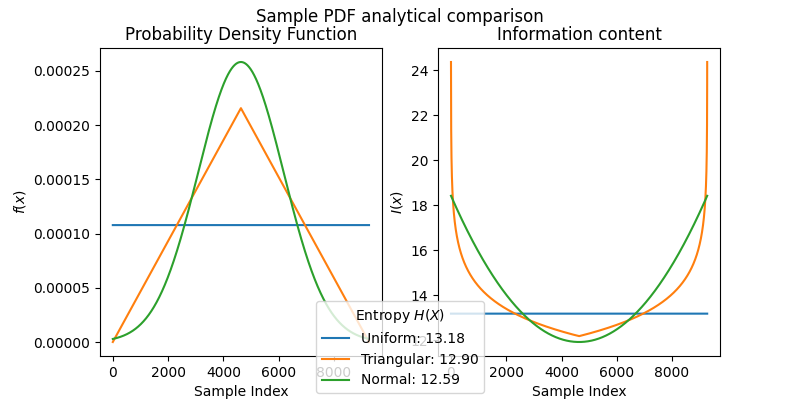

In [26]:
fig, ax = plt.subplots(1, 2, figsize=fig_size(1, 2))
fig.suptitle("Sample PDF analytical comparison")
ax[0].set_title("Probability Density Function")
ax[1].set_title("Information content")
cluster.axis_labels(ax[0], "Sample Index", "$f(x)$")
cluster.axis_labels(ax[1], "Sample Index", "$I(x)$")

for name, info in pdf_info.items():
    ax[0].plot(indices, info["F"], label=f"{name}: {info['H']:.2f}")
    ax[1].plot(indices, info["I"])
fig.legend(title="Entropy $H(X)$", loc="lower center")
fig.savefig("../images/sample:info.png")


### Sampling data

In [27]:
pdf_sample = sample.sample(indices)
partition_index = pdf_sample["Uniform"]
partition = {k: (X_S[:, v], Y_S[:, v]) for k, v in partition_index.items()}


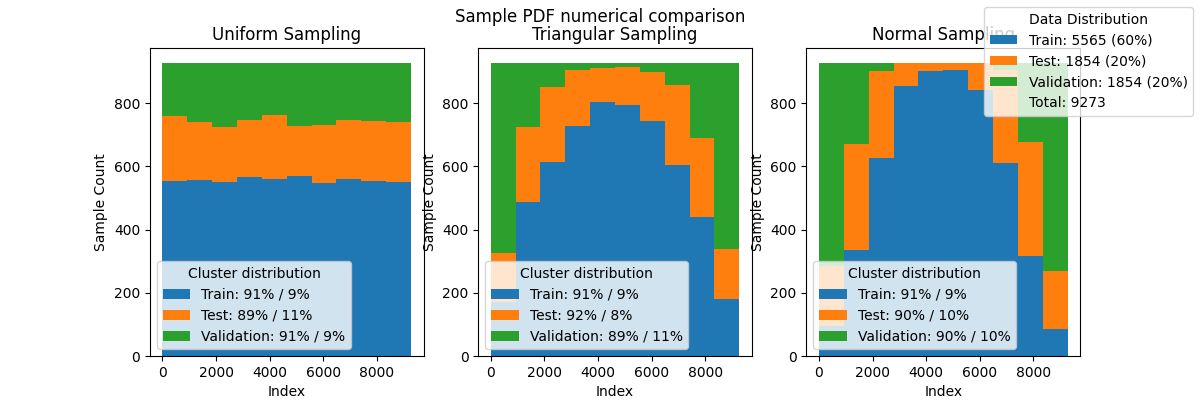

In [28]:
fig, ax = plt.subplots(1, 3, figsize=fig_size(1, 3))
fig.suptitle("Sample PDF numerical comparison")
for ax_pdf, (pdf_name, pdf_p) in zip(ax, pdf_sample.items()):
    ax_pdf.set_title(f"{pdf_name} Sampling")
    cluster.axis_labels(ax_pdf, 'Index', 'Sample Count')
    ax_pdf.hist(pdf_p.values(), stacked=True, bins=10)
    if cluster:
        ax_pdf.legend([f"{p_name}: " + " / ".join([f"{np.sum(Y_S[c, p_i])/p_i.shape[0]:.0%}"
                                                   for c in range(len(revert_Y))])
                       for p_name, p_i in pdf_p.items()],
                      title="Cluster distribution", loc="lower left")
legend = fig.legend([f"{k}: {len(v)} ({len(v)/N_S:.0%})"
                     for k, v in partition_index.items()] + [f"Total: {N_S}"],
                    title="Data Distribution", loc="upper right")
legend.legendHandles[-1].set_visible(False)
fig.savefig("../images/sample:hist")


### Data Distribution

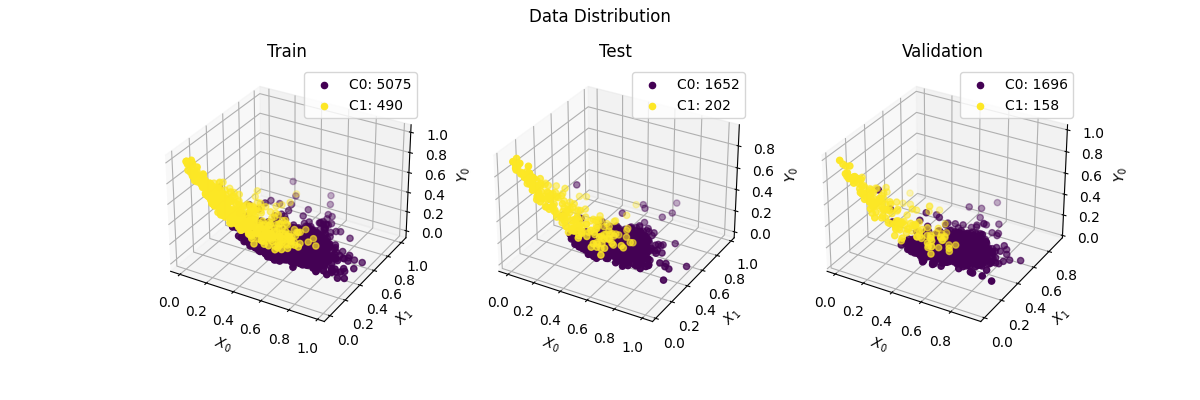

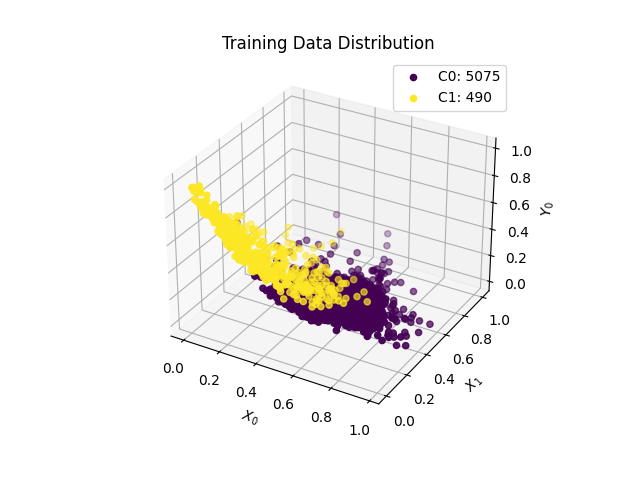

In [34]:
fig, ax = plt.subplots(1, 3, figsize=fig_size(
    1, 3), subplot_kw={'projection': '3d'})
fig.suptitle("Data Distribution")
for i, (p_name, XY) in enumerate(partition.items()):
    cluster.plot(ax[i], XY[0], XY[1], title=p_name)
fig.savefig("../images/sample:dist")

fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
cluster.plot(ax, *partition["Train"], title="Training Data Distribution")
fig.savefig("../images/sample:dist:train")

# Supervised Learning

### Linear Regression

In [30]:
B_linear, E_linear = regression.linear(*partition["Train"])
B_logistic, E_logistic = regression.logistic(*partition["Train"])


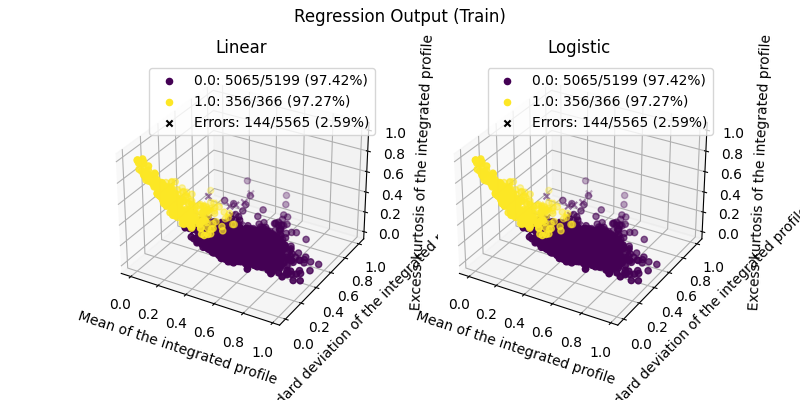

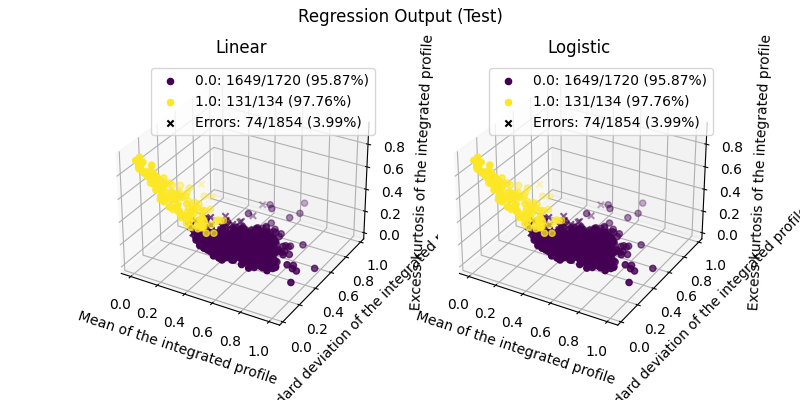

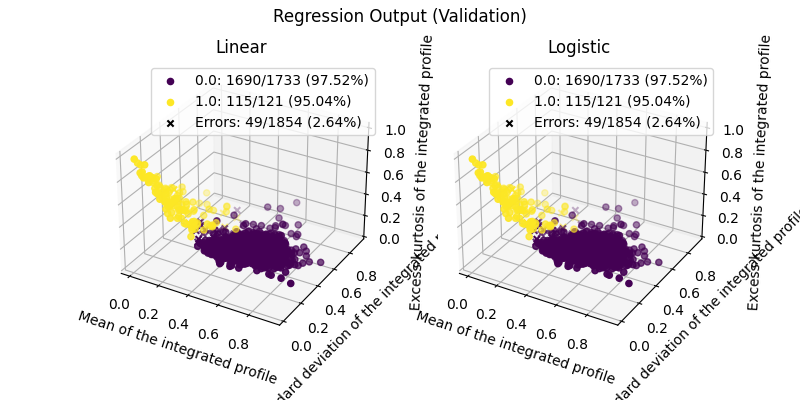

In [36]:
for name, (X, Y) in partition.items():
    fig, ax = plt.subplots(1, 2, figsize=fig_size(
        1, 2), subplot_kw={'projection': '3d'})
    fig.suptitle(f"Regression Output ({name})")
    U_linear = regression.linear_eval(X, B_linear)
    cluster.plot(ax[0], X, U_linear, Y,
                 title=f"Linear",
                 cluster_names=revert_Y, axes_names=axes_names)
    U_logistic = regression.logistic_eval(X, B_logistic)
    cluster.plot(ax[1], X, U_logistic, Y,
                 title=f"Logistic",
                 cluster_names=revert_Y, axes_names=axes_names)
    fig.savefig(f"../images/linear:{name}")


### Neural Network

In [ ]:
layers = range(3)
hidden = range(5)
epochs = 50
eta = [0.2, 0.5, 0.9]

for params in iter.product(layers, hidden, epochs, eta):
    W, B, delta_nn, Y_nn, E_nn = nn.train(partition, "Train", eta=eta,
                                        hidden=hidden, epochs=epochs, classify=classify, logs=True)
    plot_nn(delta_nn, E_nn)


In [ ]:
def plot_nn(delta_nn, E_nn):
    fig, ax = plt.subplots(1, 2, figsize=fig_size(1, 2), layout="constrained")
    ax[0].set_title("Gradients per epoch")
    ax[0].plot(range(10, epochs), delta_nn[10:],
            label=[f"{l}: {d:.2e}" for l, d in enumerate(delta_nn[-1])])
    ax[0].legend(title="Layer", loc="upper right")
    cluster.axis_labels(ax[0], "Epoch",
                        "Average Length of Gradients $\\overline{\\Vert\\delta_l\\Vert_2}$")

    ax[1].set_title("Error per epoch")
    for p_name in partition_index.keys():
        ax[1].plot(range(10, epochs), E_nn[p_name][10:],
                label=f"{p_name}: {E_nn[p_name][-1]:.2e}")
    ax[1].legend(title="Partition", loc="upper right")
    cluster.axis_labels(ax[1], "Epoch",
                        "Average Error $\\frac{\\overline{\\Vert Y_d - Y_k\\Vert_2}}{2}$")

    fig, ax = plt.subplots(1, 3, figsize=fig_size(
        1, 3), subplot_kw={'projection': '3d'})
    ax = ax.flatten()
    for n, (name, XY) in enumerate(partition.items()):
        U, _ = nn.eval(XY[0], W, B, cluster=True)
        cluster.plot(ax[n], XY[0], U, Ud=XY[1],
                    title=f"Neural Network output ({name})",
                    cluster_names=revert_Y, axes_names=axes_names)


# Unsupervised Learning

### Mountain Clustering

In [ ]:
n = int(np.power(10, 5/X_S.shape[0]))
C = mountain.run(partition["Train"][0], 1, 1, 0.1, n=n)


In [ ]:
fig, ax = plt.subplots(1, 3, figsize=fig_size(
    1, 3), subplot_kw={'projection': '3d'})
for i, (name, XY) in enumerate(partition.items()):
    U = k_means.eval(XY[0], C)
    if U.shape[0] == XY[1].shape[0]:
        U = cluster.match(U, XY[1])
        Ud = XY[1]
    else:
        Ud = None
    cluster.plot(ax[i], XY[0], U, Ud=Ud, C=C, title=f"Mountain Clustering ({name})",
                 cluster_names=revert_Y, axes_names=axes_names)
fig.savefig("mountain:clusters")


### Substractive Clustering

In [ ]:
C = mountain.run(partition["Train"][0], 1.1, 1, 0.1, substractive=True)


In [ ]:
fig, ax = plt.subplots(1, 3, figsize=fig_size(
    1, 3), subplot_kw={'projection': '3d'})
for i, (name, XY) in enumerate(partition.items()):
    U = k_means.eval(XY[0], C)
    if U.shape[0] == XY[1].shape[0]:
        U = cluster.match(U, XY[1])
        Ud = XY[1]
    else:
        Ud = None
    cluster.plot(ax[i], XY[0], U, Ud=Ud, C=C, title=f"Substractive Clustering ({name})",
                 cluster_names=revert_Y, axes_names=axes_names)
fig.savefig("substractive:clusters")

### K-Means

In [ ]:
U, C = k_means.run(2, partition["Train"][0], 0.002)


In [ ]:
fig, ax = plt.subplots(1, 3, figsize=fig_size(
    1, 3), subplot_kw={'projection': '3d'})
for i, (name, XY) in enumerate(partition.items()):
    U = k_means.eval(XY[0], C)
    if U.shape[0] == XY[1].shape[0]:
        U = cluster.match(U, XY[1])
        Ud = XY[1]
    else:
        Ud = None
    cluster.plot(ax[i], XY[0], U, Ud=Ud, C=C, title=f"K-means ({name})",
                 cluster_names=revert_Y, axes_names=axes_names)
fig.savefig("kmeans:clusters")


### Fuzzy C-means

In [ ]:
m = 5
U, C = fuzzy_c_means.run(2, partition["Train"][0], m, 0.002)


In [ ]:
fig, ax = plt.subplots(1, 3, figsize=fig_size(
    1, 3), subplot_kw={'projection': '3d'})
for i, (name, XY) in enumerate(partition.items()):
    U = fuzzy_c_means.eval(XY[0], C, m)
    if U.shape[0] == XY[1].shape[0]:
        U = cluster.match(U, XY[1])
        Ud = XY[1]
    else:
        Ud = None
    cluster.plot(ax[i], XY[0], U, Ud=Ud, C=C, title=f"Fuzzy C-means ({name})",
                 cluster_names=revert_Y, axes_names=axes_names)
fig.savefig("fuzzycmeans:clusters")
